# Week 11 - Assessed exercises

In these assessed exercises we're going to perform some model comparison on a  handwriting recognition multi-class data set. We're going to divide it up into training, validation and test sets. We're going to run different parameter  values on the training and validation sets to determine the optimal parameters Then we're going to run the optimal values on the test set to compare models

The models we're going to use are:
 - Random forests
 - k nearest neighbours
 - Multi-layer perceptron (a type of neural network)

You can load in these classifiers with the following commands

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
# Some other packages we may need
from sklearn import datasets
import numpy as np
import numpy.random as npr
import pandas as pd

In [3]:
# Load in the digits data with 
digits = datasets.load_digits()

Remember that each sklearn data set comes with a target object (the response) and a data object (the explanatory variables). 

These data concern handwriting recognition so the response is a digit (0 to 9) and the explanatory variables
are levels of grey on an 8 by 8 grid.
You can get a plot of any row (a handwriting sample) with:

Text(0.5, 1.05, '4')

<Figure size 432x288 with 0 Axes>

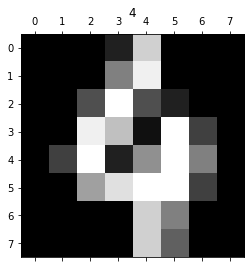

In [15]:
import matplotlib.pyplot as plt
choose_row = 100
plt.gray() 
plt.matshow(digits.images[choose_row]) 
plt.title(digits.target[choose_row])

Where here I've made the title the digit it's supposed to represent (4). Looking at the plot you should see that it resembles a 4.

Try changing the value of choose_row to see different digits and how they've been drawn. Note that this data set has an extra object 'images' that contains the 8 by 8 matrices containing the pixel intensities, we will ignore this object. 

<Figure size 432x288 with 0 Axes>

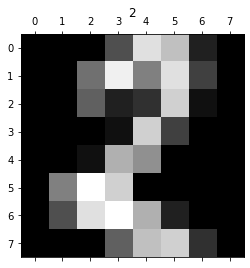

In [5]:
choose_row = 50
plt.gray() 
plt.matshow(digits.images[choose_row]) 
plt.title(digits.target[choose_row])
plt.show()

Below is a function for creating training, validation and test sets for a given
matrix of observations X and vector of responses y. The function also needs a
seed value so that it can reproduce the same outputs. The data is split 50%,
25%, 25% between training, validation and test, respectively. We will use this
function when creating our training, validation and test sets below.

In [6]:
def train_val_test_sets(X,y,s):
    npr.seed(s)
    inds= npr.permutation(range(len(y)))
    n_train = int(len(y)/2)
    n_val =  int(3*len(y)/4)
    X_train = X[inds[:n_train],:]
    y_train = y[inds[:n_train]]
    X_val = X[inds[n_train:n_val],:]
    y_val = y[inds[n_train:n_val]]
    X_test = X[inds[n_val:],:]
    y_test = y[inds[n_val:]]
    return X_train, X_val, X_test, y_train, y_val, y_test

### Q1 Write a function that runs each of the three classifiers with their default  parameter values. The function inputs are the training and test sets X_train, X_test, y_train, y_test and a seed value s. The seed value should be used as the random_state argument in RandomForestClassifier and MLPClassifier. The function should return a dict with keys 'knn', 'rf' and 'svm'. The values should be the misclassification rate for each classifier (rounded to 3dp). Remember that  there are more than two categories, so your mis-classification table will have more rows and columns to interpret.

In [7]:
def exercise1(X_train,X_test,y_train,y_test,s):

    def misclassification_cross(y_test,test_pred):
        cross = pd.crosstab(test_pred,y_test).to_numpy()
        return (cross.sum() - (np.diagonal(cross)).sum())/(cross).sum()
                    
    rf = RandomForestClassifier(random_state=s)
    rf_fit = rf.fit(X_train,y_train)
    rf_test_pred = rf_fit.predict(X_test)    
    rf_error_rate = misclassification_cross(y_test,rf_test_pred)
    
    kn = KNeighborsClassifier()
    kn_fit = kn.fit(X_train,y_train)
    kn_test_pred = kn_fit.predict(X_test)
    kn_error_rate = misclassification_cross(y_test,kn_test_pred)
    
    mlp = MLPClassifier(random_state=s)
    mlp_fit = mlp.fit(X_train,y_train)
    mlp_test_pred = mlp_fit.predict(X_test)
    mlp_error_rate = misclassification_cross(y_test,mlp_test_pred)

    
    return {'knn':round(kn_error_rate,3),'mlp':round(mlp_error_rate,3),'rf':round(rf_error_rate,3)}

In [8]:
# Suggested test
X1 = digits.data
y1 = digits.target
# We can use underscores to ignore the outputs of train_val_test_sets that we don't need
[X_train1, _, X_test1, y_train1, _, y_test1] = train_val_test_sets(X1,y1,99)
print(exercise1(X_train1,X_test1,y_train1,y_test1,123))
# This should return 
# {'knn': 0.024, 'mlp': 0.031, 'rf': 0.076}
# You can ignore the warning messages for now
# Again, this should return the same answer every time you run it with the inputs
# X2, y2 and 99. If you use a subset of X2 and y2, or change the seed value you 
# should expect these values to change.

{'knn': 0.024, 'mlp': 0.031, 'rf': 0.076}


Each of the above models has key parameters which we might like to estimate. For 
example, we might want to estimate the 'best' number of neighbours to use in kNN
To do this, we fit kNN with different values of k to the training set and evaluate
the performance of each model using the validation set. The k value that gives the
best performance on the validation data is chosen as the best model. We then 
evaluate the performance of this model on data the classifier hasn't seen before,
the test set.

### Q2 Write a function that determines the 'best' number of neighbours k to use in  the kNN classifier and evaluates the performance of the best model on the test set. The function inputs are the training, validation and test sets and a list of  values of k to try. The function should return a dict with the best k value (key:  'k') and the misclassification rate for the test set (key: 'MR') (rounded to 3dp). Ensure that you use these exact keys.

In [9]:
def exercise2(X_train,X_val,X_test,y_train,y_val,y_test,kvals):
    
    def misclassification_cross(y_test,test_pred):
        cross = pd.crosstab(test_pred,y_test).to_numpy()
        return (cross.sum() - (np.diagonal(cross)).sum())/(cross).sum()
    
    misclassification_rate = []
    for i in kvals:
            kn = KNeighborsClassifier(i)
            kn_fit = kn.fit(X_train,y_train)
            kn_test_pred = kn_fit.predict(X_val)
            kn_error_rate = misclassification_cross(y_val,kn_test_pred)
            misclassification_rate.append(kn_error_rate)
            
    kn = KNeighborsClassifier(kvals[np.argmin(misclassification_rate)])
    kn_fit = kn.fit(X_train,y_train)
    kn_test_pred = kn_fit.predict(X_test)
    kn_error_rate = misclassification_cross(y_test,kn_test_pred)
            
    return {'k':kvals[np.argmin(misclassification_rate)],'MR':round(kn_error_rate,3)}

In [10]:
# Suggestes test
print(exercise2(*train_val_test_sets(X1,y1,199),range(1,22)))
# This should return {'k': 2, 'MR': 0.031}
# If you change the seed value for creating your training, validation and test sets
# you can expect to get different values for k and the missclassification rate.

{'k': 2, 'MR': 0.031}


### Q3 Write a function that determines the 'best' number of trees (n_estimators) to use in the random forest classifier and evaluates the performance of the best model on the test set. The function inputs are the training, validation and test sets, a list of values of n_estimators to try and a seed value s to use as the random_stat for the classifier. The function should return a dict with the best number of trees (key: 'Trees') and the misclassification rate for the test set (key: 'MR') (rounded to 3dp) Ensure that you use these exact keys.

In [11]:
def exercise3(X_train,X_val,X_test,y_train,y_val,y_test,tree_vals,s):
    
    def misclassification_cross(y_test,test_pred):
        cross = pd.crosstab(test_pred,y_test).to_numpy()
        return (cross.sum() - (np.diagonal(cross)).sum())/(cross).sum()
    
    misclassification_rate = []
    for i in tree_vals:
            rf = RandomForestClassifier(n_estimators=i,random_state=s)
            rf_fit = rf.fit(X_train,y_train)
            rf_test_pred = rf_fit.predict(X_val)
            rf_error_rate = misclassification_cross(y_val,rf_test_pred)
            misclassification_rate.append(rf_error_rate)
            
    rf = RandomForestClassifier(n_estimators=tree_vals[np.argmin(misclassification_rate)],random_state=s)
    rf_fit = rf.fit(X_train,y_train)
    rf_test_pred = rf_fit.predict(X_test)
    rf_error_rate = misclassification_cross(y_test,rf_test_pred)
        
    return {'Trees':tree_vals[np.argmin(misclassification_rate)],'MR':round(rf_error_rate,3)}

In [12]:
# Suggestes test
print(exercise3(*train_val_test_sets(X1,y1,99),range(5,101,5),23))
# This should return {'Trees': 55, 'MR': 0.038}
# Again, changing the seed value for creating your training, validation and test sets
# will change the number of trees and the missclassification rate. As will changing
# the seed value for the random state of the classifier

{'Trees': 55, 'MR': 0.038}


### Q4 The parameter we wish to estimate for the multi-layer perceptron classifier is the number of neurons in the hidden layers of the neural network. To change this parameter include hidden_layer_sizes=num_neurons as an input to the MLPClassifier function. Write a function that determines the 'best' number of neurons in the  multi-layer perceptron classifier and evaluates the performance of the best model  on the test set. The function inputs are the training, validation and test sets,  a list of values of hidden_layer_sizes to try and a seed value s to use as the  random_state for the classifier. The function should return a dict with the best number of neurons (key: 'Neurons') and the  misclassification rate for the test  set (key: 'MR') (rounded to 3dp). Ensure that you use these exact keys.

In [13]:
def exercise4(X_train,X_val,X_test,y_train,y_val,y_test,layer_vals,s):
    
    def misclassification_cross(y_test,test_pred):
        cross = pd.crosstab(test_pred,y_test).to_numpy()
        return (cross.sum() - (np.diagonal(cross)).sum())/(cross).sum()
    
    misclassification_rate = []
    for i in layer_vals:
            mlp = MLPClassifier(hidden_layer_sizes=i,random_state=s)
            mlp_fit = mlp.fit(X_train,y_train)
            mlp_test_pred = mlp_fit.predict(X_val)
            mlp_error_rate = misclassification_cross(y_val,mlp_test_pred)
            misclassification_rate.append(mlp_error_rate)
            
    mlp = MLPClassifier(hidden_layer_sizes=layer_vals[np.argmin(misclassification_rate)],random_state=s)
    mlp_fit = mlp.fit(X_train,y_train)
    mlp_test_pred = mlp_fit.predict(X_test)
    mlp_error_rate = misclassification_cross(y_test,mlp_test_pred)
            
    return {'Neurons':layer_vals[np.argmin(misclassification_rate)],'MR':round(mlp_error_rate,3)}

In [14]:
# Suggested test
print(exercise4(*train_val_test_sets(X1,y1,175),range(50,1551,100),45))
# This should return {'Neurons': 550, 'MR': 0.033}
# As before, changing either seed value will change the number of neurons and the 
# missclassification rate.
# Note that this function will take ~20s to run

{'Neurons': 550, 'MR': 0.033}
